In [0]:
import pandas as pd, numpy as np
import sys, os, cv2, random, shutil,time                                                                                                                                                      
import PIL
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
from sklearn.model_selection import KFold,StratifiedKFold

import sklearn.metrics as skmetrics

In [0]:
from fastai_extensions import *
from efficientnet_pytorch import EfficientNet
import albumentations as A

In [0]:
RANDOM_STATE = 41
def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
fix_seed(RANDOM_STATE)

In [0]:
DATA_DIR = 'data/'
df_train = pd.read_csv(f'{DATA_DIR}/Train.csv')
df_test = pd.read_csv(f'{DATA_DIR}/Test.csv')
MODEL_DIR = '../../models' #save models to current directory

In [0]:
df_train['path']  = df_train['ID']+'.jpg'
df_train['Label']  = df_train['Label'].astype(np.int8)

In [0]:
def tensor2np(x):
    np_image = x.cpu().permute(1, 2, 0).numpy()
    np_image = (np_image * 255).astype(np.uint8)
    
    return np_image

def alb_tfm2fastai(alb_tfm):
    def _alb_transformer(x):
        np_image = tensor2np(x)
        transformed = alb_tfm(image=np_image)['image']
        tensor_image = pil2tensor(transformed, np.float32)
        tensor_image.div_(255)
        return tensor_image

    transformer = TfmPixel(_alb_transformer)
    
    return transformer()

In [0]:
def get_augs(p=1.0):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.RGBShift(p=0.1, r_shift_limit=(-5, 5), g_shift_limit=(-5, 5), b_shift_limit=(-5, 5)),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.1, border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.MedianBlur(p=1.0, blur_limit=7),
            A.Blur(p=1.0, blur_limit= 7),
            A.GaussianBlur(p=1.0, blur_limit=7),
        ], p=0.05),
        A.OneOf([
            A.ElasticTransform(p=1.0, alpha=1.0, sigma=30, alpha_affine=20),
            A.GridDistortion(p=1.0, num_steps=5, distort_limit=0.1),
            A.OpticalDistortion(p=1.0, distort_limit=0.1, shift_limit=0.5)
        ], p=0.1)
    ],  p=p)


In [0]:
size=200
bs = 16
path = Path('data/train')

alb_tfms = alb_tfm2fastai(get_augs())
tfms = get_transforms(do_flip=False,
                      flip_vert=False,
                      max_lighting=0.,
                      max_rotate=0.,
                      xtra_tfms=alb_tfms)

In [0]:
n_splits=5
base_model_name = 'effnet5_'
df_oof = df_train.copy()
y_valid_preds=[]; y_test_preds = []
kfold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)
for i, (ix_train, ix_val) in enumerate(kfold.split(X=df_train, y=df_train.Label)):
  fix_seed(RANDOM_STATE)

  model_name = base_model_name+'E'+str(i)
  train = df_train.iloc[ix_train]
  val = df_train.iloc[ix_val]
  data = (ImageList.from_df(path=path,df=df_train[['path','Label']])
        .split_by_idxs(ix_train, ix_val)
        .label_from_df()
        .transform(tfms,size=size)
        .databunch(bs=bs, num_workers=4)
        .normalize(imagenet_stats))
  break
  

In [0]:
pos = np.sum(df_train.Label)
neg = df_train.shape[0] - pos
weights = torch.FloatTensor([1, neg / pos])
weights = weights.to(device)
weights

tensor([1.0000, 2.9132], device='cuda:0')

In [0]:
fix_seed(RANDOM_STATE)
model = EfficientNet.from_pretrained('efficientnet-b5',num_classes=2) 
learn = Learner(data, model,
                loss_func=nn.CrossEntropyLoss(weight=weights),
                metrics=[accuracy],
                callback_fns=[BnFreeze]
               )
learn.split( lambda m: (model._conv_head,) )
learn.model_dir = MODEL_DIR

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-02
Min loss divided by 10: 2.09E-03


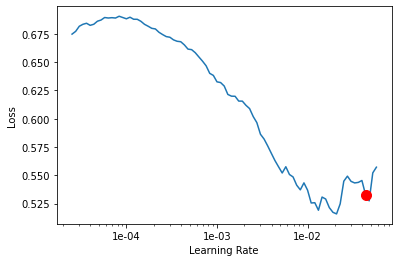

In [0]:
fix_seed(RANDOM_STATE)
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e-1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.289385,0.445889,0.826138,02:22
1,0.377667,0.297925,0.922987,02:22
2,0.292455,0.319853,0.917153,02:22
3,0.238994,0.353022,0.897316,02:22
4,0.285433,0.130855,0.950992,02:22
5,0.194260,0.111093,0.952159,02:22
6,0.200171,0.138449,0.941657,02:22
7,0.124919,0.095042,0.963827,02:22
8,0.120473,0.088108,0.963827,02:22
9,0.116250,0.090627,0.960327,02:22


Better model found at epoch 0 with valid_loss value: 0.44588902592658997.
Better model found at epoch 1 with valid_loss value: 0.29792463779449463.
Better model found at epoch 4 with valid_loss value: 0.1308552473783493.
Better model found at epoch 5 with valid_loss value: 0.11109313368797302.
Better model found at epoch 7 with valid_loss value: 0.0950421616435051.
Better model found at epoch 8 with valid_loss value: 0.08810817450284958.


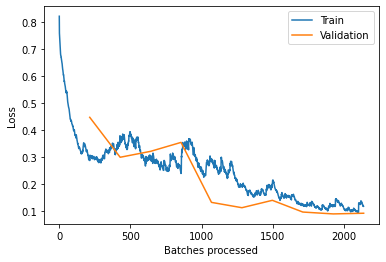

In [0]:
# train head
learn.fit_one_cycle(10, max_lr=8e-3, wd=5e-3, moms=(0.9, 0.8),callbacks=[SaveModelCallback(learn, monitor='valid_loss', mode='min', name=model_name+'P0')])
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 7.59E-08


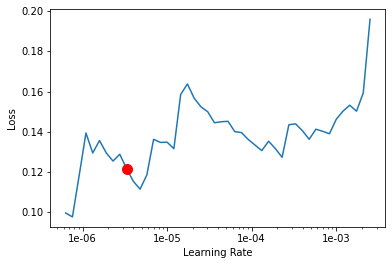

In [0]:
fix_seed(RANDOM_STATE)
learn.load(model_name+'P0')
learn.unfreeze()
learn.lr_find(wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.108563,0.087734,0.960327,03:17
1,0.084849,0.090592,0.961494,03:17
2,0.101275,0.087161,0.966161,03:17
3,0.090165,0.087807,0.964994,03:18
4,0.088405,0.087982,0.963827,03:17


Better model found at epoch 0 with valid_loss value: 0.08773423731327057.
Better model found at epoch 2 with valid_loss value: 0.08716080337762833.


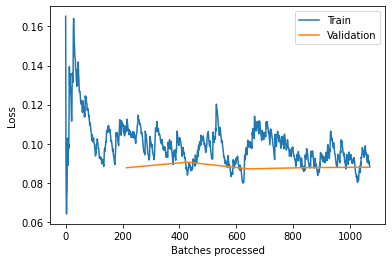

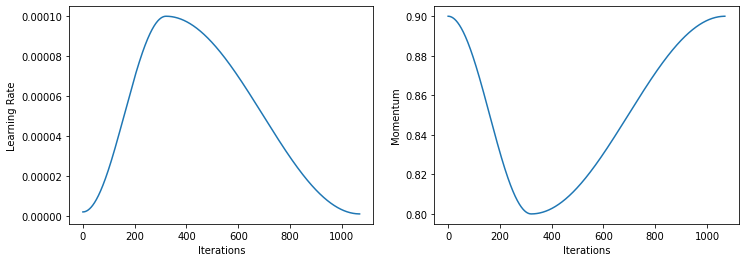

In [0]:
# train all layers-- <best
fix_seed(RANDOM_STATE)
learn.load(model_name+'P0')
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8),callbacks=[SaveModelCallback(learn, monitor='valid_loss', mode='min', name=model_name+'P1')])
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)